## 读取数据集

In [2]:
import re
import collections
def read_book():
    with open("book.txt",'r') as f:
        lines = f.read().split(".")
        return [re.sub('[^A-Za-z]+', ' ', line) for line in lines]

lines = read_book()[1:-1]
print(f'# 文本总行数: {len(lines)}')
print(lines[-1])


# 文本总行数: 5184
 His soul swooned slowly as he heard the snow falling faintly through the universe and faintly falling like the descent of their last end upon all the living and the dead


## TF-IDF

In [3]:
import math
def TFIDF(lines):
    tf_idf = {}
    tf_dic = {}
    idf_dic = {}
    N = len(lines)
    words = [word for line in lines for word in line.split()]
    frequency = collections.Counter(words)
    for word,freq in frequency.items():
        tf = math.log(freq/len(words)+1)
        tf_dic[word] = tf
        idf = 0
        for line in lines:
            if word in line:
                idf+= 1
        idf = math.log(N/idf)
        idf_dic[word] = idf
        tf_idf[word] = tf*idf
    return tf_dic,idf_dic,tf_idf                

tf,idf,tf_idf = TFIDF(lines)
print("their:")
print("\ntf: ", tf['their'])
print("\nidf: ",idf['their'])
print("\ntf-idf: ",tf_idf['their'])

their:

tf:  0.0019930106825200846

idf:  3.817133789637615

tf-idf:  0.00760758841935614


In [4]:
## 使用 nltk 计算 tf-idf
from nltk.text import TextCollection
words = [line.split() for line in lines]
corpus = TextCollection(words)
tf_idf = corpus.tf_idf('their',corpus)
tf = corpus.tf('their',corpus)
idf = corpus.idf('their')
print("their:")
print("\ntf: ", tf)
print("\nidf: ",idf)
print("\ntf-idf: ",tf_idf)

their:

tf:  0.0019949980483714744

idf:  3.834833366737016

tf-idf:  0.007650485082470158


## FFNNLM（前馈神经网络语言模型）
### 构建词表

In [5]:
def count_corpus(tokens):
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)


class Vocab:
    def __init__(self,tokens=None, min_freq=0, reversed_tokens=None):
        if tokens is None:
            tokens = []
        if reversed_tokens is None:
            reversed_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(),key= lambda x:x[1], reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reversed_tokens
        self.token_to_idx = {tokens:idx for idx,tokens in enumerate(self.idx_to_token)}

        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token)-1
    
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list,tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self, indices):
        if not isinstance(indices, (list,tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]
    
    @property
    def unk(self):
        return 0
    
    @property
    def token_freqs(self):
        return self._token_freqs

In [6]:
BOS_TOKEN = "<bos>"
EOS_TOKEN = "<eos>"
PAD_TOKEN = '<pad>'

vocab = Vocab(words, reversed_tokens=[BOS_TOKEN,EOS_TOKEN,PAD_TOKEN])
print(list(vocab.token_to_idx.items())[:10])
print(vocab.idx_to_token[:10])
print(len(vocab))

[('<unk>', 0), ('<bos>', 1), ('<eos>', 2), ('<pad>', 3), ('the', 4), ('and', 5), ('of', 6), ('to', 7), ('a', 8), ('was', 9)]
['<unk>', '<bos>', '<eos>', '<pad>', 'the', 'and', 'of', 'to', 'a', 'was']
7680


In [7]:
vocab.token_to_idx[BOS_TOKEN]

1

### 构建NN

In [8]:
import torch
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class NGramDataset(Dataset):
    def __init__(self, corpus,vocab, context_size=2):
        self.data = []
        self.bos = vocab.idx_to_token[vocab.token_to_idx[BOS_TOKEN]]
        self.eos = vocab.idx_to_token[vocab.token_to_idx[EOS_TOKEN]]
        for line in tqdm(corpus,desc="Dataset Construct"):
            if len(line) < context_size:
                continue
            for i in range(context_size,len(line.split())):
                context = line.split()[i-context_size:i]
                target = line.split()[i]
                self.data.append((vocab[context],vocab[target]))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        return self.data[i]
    
    def collate_fn(self, examples):
        inputs = torch.tensor([ex[0] for ex in examples])
        targets = torch.tensor([list(ex)[1] for ex in examples])
        return (inputs, targets)
    


class FFNNLM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size, hidden_dim):
        super(FFNNLM, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size*embedding_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, vocab_size)
        self.activate = F.relu
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if "embedding" not in name:
                torch.nn.init.uniform_(param,a=-0.1,b=0.1)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((inputs.shape[0],-1))
        hidden = self.activate(self.linear1(embeds))
        output = self.linear2(hidden)
        log_probs = F.log_softmax(output, dim=1)
        return log_probs

In [15]:
embedding_dim = 64
context_size = 4
hidden_dim = 128
batch_size = 1024
num_epoch = 100

dataset = NGramDataset(lines,vocab,context_size)
dataloader = DataLoader(dataset,batch_size=batch_size,collate_fn=dataset.collate_fn,shuffle=True)
criterion = nn.NLLLoss()
device = torch.device('mps' if torch.backends.mps.is_available() else "cpu")
model = FFNNLM(len(vocab), embedding_dim, context_size,hidden_dim)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()
total_losses = []

for epoch in range(num_epoch):
    total_loss = 0
    for batch in tqdm(dataloader, desc=f"Training Epoch{epoch}"):
        inputs, targets = [x.to(device) for x in batch]
        optimizer.zero_grad()
        log_probs = model(inputs)
        loss = criterion(log_probs, targets)
        loss.backward()
        optimizer.step()
        total_loss+= loss.item()
    print(total_loss)
    total_losses.append(total_loss)

Dataset Construct:   0%|          | 0/5184 [00:00<?, ?it/s]

Training Epoch0:   0%|          | 0/51 [00:00<?, ?it/s]

396.24623441696167


Training Epoch1:   0%|          | 0/51 [00:00<?, ?it/s]

321.2981810569763


Training Epoch2:   0%|          | 0/51 [00:00<?, ?it/s]

302.5915641784668


Training Epoch3:   0%|          | 0/51 [00:00<?, ?it/s]

287.56204986572266


Training Epoch4:   0%|          | 0/51 [00:00<?, ?it/s]

272.5179977416992


Training Epoch5:   0%|          | 0/51 [00:00<?, ?it/s]

257.2415370941162


Training Epoch6:   0%|          | 0/51 [00:00<?, ?it/s]

241.05612659454346


Training Epoch7:   0%|          | 0/51 [00:00<?, ?it/s]

223.31572818756104


Training Epoch8:   0%|          | 0/51 [00:00<?, ?it/s]

204.8594090938568


Training Epoch9:   0%|          | 0/51 [00:00<?, ?it/s]

187.3142638206482


Training Epoch10:   0%|          | 0/51 [00:00<?, ?it/s]

172.98214626312256


Training Epoch11:   0%|          | 0/51 [00:00<?, ?it/s]

161.8591389656067


Training Epoch12:   0%|          | 0/51 [00:00<?, ?it/s]

153.96734833717346


Training Epoch13:   0%|          | 0/51 [00:00<?, ?it/s]

147.40804481506348


Training Epoch14:   0%|          | 0/51 [00:00<?, ?it/s]

141.64391088485718


Training Epoch15:   0%|          | 0/51 [00:00<?, ?it/s]

136.8999741077423


Training Epoch16:   0%|          | 0/51 [00:00<?, ?it/s]

132.56900334358215


Training Epoch17:   0%|          | 0/51 [00:00<?, ?it/s]

128.12947463989258


Training Epoch18:   0%|          | 0/51 [00:00<?, ?it/s]

124.64132475852966


Training Epoch19:   0%|          | 0/51 [00:00<?, ?it/s]

121.33000326156616


Training Epoch20:   0%|          | 0/51 [00:00<?, ?it/s]

118.22473382949829


Training Epoch21:   0%|          | 0/51 [00:00<?, ?it/s]

114.95947647094727


Training Epoch22:   0%|          | 0/51 [00:00<?, ?it/s]

112.25889015197754


Training Epoch23:   0%|          | 0/51 [00:00<?, ?it/s]

109.19596791267395


Training Epoch24:   0%|          | 0/51 [00:00<?, ?it/s]

106.90535247325897


Training Epoch25:   0%|          | 0/51 [00:00<?, ?it/s]

104.4155284166336


Training Epoch26:   0%|          | 0/51 [00:00<?, ?it/s]

101.84089934825897


Training Epoch27:   0%|          | 0/51 [00:00<?, ?it/s]

99.68476998806


Training Epoch28:   0%|          | 0/51 [00:00<?, ?it/s]

97.4443382024765


Training Epoch29:   0%|          | 0/51 [00:00<?, ?it/s]

95.09939682483673


Training Epoch30:   0%|          | 0/51 [00:00<?, ?it/s]

93.3386367559433


Training Epoch31:   0%|          | 0/51 [00:00<?, ?it/s]

91.51414322853088


Training Epoch32:   0%|          | 0/51 [00:00<?, ?it/s]

89.40767681598663


Training Epoch33:   0%|          | 0/51 [00:00<?, ?it/s]

87.30835378170013


Training Epoch34:   0%|          | 0/51 [00:00<?, ?it/s]

85.85122621059418


Training Epoch35:   0%|          | 0/51 [00:00<?, ?it/s]

83.8013870716095


Training Epoch36:   0%|          | 0/51 [00:00<?, ?it/s]

81.9624662399292


Training Epoch37:   0%|          | 0/51 [00:00<?, ?it/s]

80.71828329563141


Training Epoch38:   0%|          | 0/51 [00:00<?, ?it/s]

78.99560034275055


Training Epoch39:   0%|          | 0/51 [00:00<?, ?it/s]

77.09763872623444


Training Epoch40:   0%|          | 0/51 [00:00<?, ?it/s]

75.73628664016724


Training Epoch41:   0%|          | 0/51 [00:00<?, ?it/s]

74.23658871650696


Training Epoch42:   0%|          | 0/51 [00:00<?, ?it/s]

72.64300656318665


Training Epoch43:   0%|          | 0/51 [00:00<?, ?it/s]

71.27779114246368


Training Epoch44:   0%|          | 0/51 [00:00<?, ?it/s]

69.76349902153015


Training Epoch45:   0%|          | 0/51 [00:00<?, ?it/s]

68.40042078495026


Training Epoch46:   0%|          | 0/51 [00:00<?, ?it/s]

67.08287858963013


Training Epoch47:   0%|          | 0/51 [00:00<?, ?it/s]

65.64430630207062


Training Epoch48:   0%|          | 0/51 [00:00<?, ?it/s]

64.37830150127411


Training Epoch49:   0%|          | 0/51 [00:00<?, ?it/s]

62.85184180736542


Training Epoch50:   0%|          | 0/51 [00:00<?, ?it/s]

61.76013112068176


Training Epoch51:   0%|          | 0/51 [00:00<?, ?it/s]

60.38304674625397


Training Epoch52:   0%|          | 0/51 [00:00<?, ?it/s]

59.31418859958649


Training Epoch53:   0%|          | 0/51 [00:00<?, ?it/s]

58.288321018218994


Training Epoch54:   0%|          | 0/51 [00:00<?, ?it/s]

56.93103575706482


Training Epoch55:   0%|          | 0/51 [00:00<?, ?it/s]

55.802729070186615


Training Epoch56:   0%|          | 0/51 [00:00<?, ?it/s]

54.714656710624695


Training Epoch57:   0%|          | 0/51 [00:00<?, ?it/s]

53.81751161813736


Training Epoch58:   0%|          | 0/51 [00:00<?, ?it/s]

52.51241463422775


Training Epoch59:   0%|          | 0/51 [00:00<?, ?it/s]

51.489251255989075


Training Epoch60:   0%|          | 0/51 [00:00<?, ?it/s]

50.61064684391022


Training Epoch61:   0%|          | 0/51 [00:00<?, ?it/s]

49.46571397781372


Training Epoch62:   0%|          | 0/51 [00:00<?, ?it/s]

48.64267581701279


Training Epoch63:   0%|          | 0/51 [00:00<?, ?it/s]

47.580963134765625


Training Epoch64:   0%|          | 0/51 [00:00<?, ?it/s]

46.60788029432297


Training Epoch65:   0%|          | 0/51 [00:00<?, ?it/s]

45.55574285984039


Training Epoch66:   0%|          | 0/51 [00:00<?, ?it/s]

44.578327000141144


Training Epoch67:   0%|          | 0/51 [00:00<?, ?it/s]

43.72814232110977


Training Epoch68:   0%|          | 0/51 [00:00<?, ?it/s]

42.85780227184296


Training Epoch69:   0%|          | 0/51 [00:00<?, ?it/s]

41.936247408390045


Training Epoch70:   0%|          | 0/51 [00:00<?, ?it/s]

41.19383490085602


Training Epoch71:   0%|          | 0/51 [00:00<?, ?it/s]

40.42237836122513


Training Epoch72:   0%|          | 0/51 [00:00<?, ?it/s]

39.81897985935211


Training Epoch73:   0%|          | 0/51 [00:00<?, ?it/s]

38.72661179304123


Training Epoch74:   0%|          | 0/51 [00:00<?, ?it/s]

38.04624831676483


Training Epoch75:   0%|          | 0/51 [00:00<?, ?it/s]

37.04764884710312


Training Epoch76:   0%|          | 0/51 [00:00<?, ?it/s]

36.48424834012985


Training Epoch77:   0%|          | 0/51 [00:00<?, ?it/s]

35.73948061466217


Training Epoch78:   0%|          | 0/51 [00:00<?, ?it/s]

34.93819588422775


Training Epoch79:   0%|          | 0/51 [00:00<?, ?it/s]

34.37361037731171


Training Epoch80:   0%|          | 0/51 [00:00<?, ?it/s]

33.62282055616379


Training Epoch81:   0%|          | 0/51 [00:00<?, ?it/s]

32.90545129776001


Training Epoch82:   0%|          | 0/51 [00:00<?, ?it/s]

32.13221198320389


Training Epoch83:   0%|          | 0/51 [00:00<?, ?it/s]

31.447268187999725


Training Epoch84:   0%|          | 0/51 [00:00<?, ?it/s]

30.840214729309082


Training Epoch85:   0%|          | 0/51 [00:00<?, ?it/s]

30.24766319990158


Training Epoch86:   0%|          | 0/51 [00:00<?, ?it/s]

29.613442301750183


Training Epoch87:   0%|          | 0/51 [00:00<?, ?it/s]

28.95821338891983


Training Epoch88:   0%|          | 0/51 [00:00<?, ?it/s]

28.29846966266632


Training Epoch89:   0%|          | 0/51 [00:00<?, ?it/s]

27.776173770427704


Training Epoch90:   0%|          | 0/51 [00:00<?, ?it/s]

27.10165622830391


Training Epoch91:   0%|          | 0/51 [00:00<?, ?it/s]

26.63994938135147


Training Epoch92:   0%|          | 0/51 [00:00<?, ?it/s]

26.092439621686935


Training Epoch93:   0%|          | 0/51 [00:00<?, ?it/s]

25.39412486553192


Training Epoch94:   0%|          | 0/51 [00:00<?, ?it/s]

24.86144906282425


Training Epoch95:   0%|          | 0/51 [00:00<?, ?it/s]

24.400433719158173


Training Epoch96:   0%|          | 0/51 [00:00<?, ?it/s]

23.823719650506973


Training Epoch97:   0%|          | 0/51 [00:00<?, ?it/s]

23.36325192451477


Training Epoch98:   0%|          | 0/51 [00:00<?, ?it/s]

22.864242732524872


Training Epoch99:   0%|          | 0/51 [00:00<?, ?it/s]

22.52092331647873


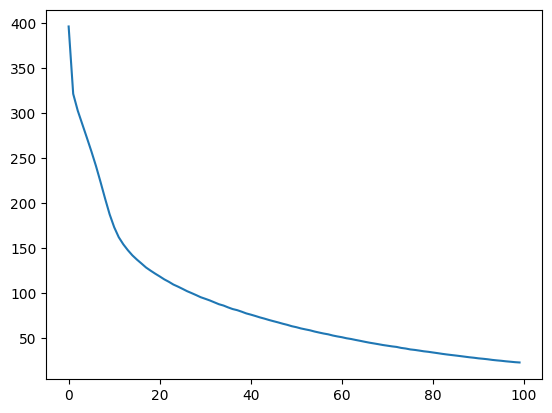

In [19]:
import matplotlib.pyplot as plt
plt.plot(range(num_epoch),total_losses)

In [20]:
vector = model.embeddings.weight.data
vector

tensor([[-0.3564,  0.4703,  1.3561,  ...,  0.2047, -0.5250, -0.0153],
        [ 0.2669, -0.1422, -0.4655,  ..., -0.6783, -0.4777,  1.3970],
        [-0.0346,  1.6248, -0.5637,  ..., -0.8232,  0.3723, -1.9382],
        ...,
        [-1.2149, -1.6070, -0.1865,  ..., -0.2810,  0.1537, -0.8987],
        [-0.0252,  0.3979,  0.2700,  ..., -1.0127,  0.2330,  0.7547],
        [ 0.4815, -2.0542,  1.1466,  ...,  0.0261,  0.8464,  1.9166]],
       device='mps:0')

## LSTMLM

In [28]:
class RNNLM(nn.Module):
    def __init__(self, vocab_size, embedding_dim,hidden_dim,num_layers):
        super(RNNLM, self).__init__()
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.lstm = nn.LSTM(embedding_dim,hidden_dim,num_layers,batch_first=True)
        self.linear = nn.Linear(hidden_dim,vocab_size)
        
    
    def forward(self,x,h):
        x = self.embedding(x)
        out, (h,c) = self.lstm(x,h)
        out = out.reshape(out.size(0)*out.size(1),out.size(2))
        out = self.linear(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs, (h,c)
    
vocab_size = len(vocab)
embedding_dim = 64
hidden_dim = 128
num_layers = 1
batch_size = 1024
num_epoch = 10
context_size = 4

model = RNNLM(vocab_size,embedding_dim,hidden_dim,num_layers).to(device)

In [30]:
from torch.nn.utils import clip_grad_norm_
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
dataloader = DataLoader(dataset,batch_size=batch_size,collate_fn=dataset.collate_fn,shuffle=True)
def detach(states):
    return [state.detach() for state in states]

for epoch in range(num_epoch):
    states = (torch.zeros(num_layers,batch_size,hidden_dim).to(device),
              torch.zeros(num_layers,batch_size,hidden_dim).to(device))
    total_loss = 0
    for batch in tqdm(dataloader, desc=f"Training Epoch{epoch}"):
        inputs, targets = [x.to(device) for x in batch]
        states = detach(states)
        outputs,states = model(inputs, states)
        loss = criterion(outputs,targets.reshape(-1))
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(),0.5)
        total_loss+= loss.item()
    print(total_loss)
    total_losses.append(total_loss)
    

Training Epoch0:   0%|          | 0/51 [00:00<?, ?it/s]

ValueError: Expected input batch_size (4096) to match target batch_size (1024).